1. Cleaning
2. Preproccesing
3. Heatmap correlation
4. Feature selection
5. Try different models
6. Varianter: Both count/registered separately and together. Dela upp datasetet i day n night t.ex.? Snitt av modeller.

In [184]:
import math
import sklearn
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [185]:
#Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sampleSubmission_df = pd.read_csv('sampleSubmission.csv')

## Data Preprocessing

In [186]:
#Insert new column for hour, value between 0 - 23.
lst = []
for index, row in train_df.iterrows():
    row['time'] = row['datetime'].split()[1][0] + row['datetime'].split()[1][1]
    if row['time'][0] == 0:
        lst.append(int(row['time'][1]))
    else: lst.append(int(row['time']))

train_df.insert(1, "time", lst, True)    

lst = []
for index, row in test_df.iterrows():
    row['time'] = row['datetime'].split()[1][0] + row['datetime'].split()[1][1]
    if row['time'][0] == 0:
        lst.append(int(row['time'][1]))
    else: lst.append(int(row['time']))

test_df.insert(1, "time", lst, True)    

In [187]:
# Scale function
def scale(data, high, low):
    mins = np.min(data, axis=0)
    maxs = np.max(data, axis=0)
    rng = maxs - mins
    return high - (((high - low) * (maxs - data)) / rng)

In [241]:

#Plot function
def plot(name, y_true, y_pred): 
    figure, axes = plt.subplots(ncols=2)
    figure.set_size_inches(10, 4)

    sns.distplot(y_true, ax=axes[0], bins=50)
    axes[0].set_title('Validation Data Distribution')
    sns.distplot(y_pred, ax=axes[1], bins=50)
    axes[1].set_title('Predicted Validation Data Distribution')

    figure.show()
    plt.savefig(name, dpi=400)

In [189]:
#Select target variable, "count" as y
y = train_df.iloc[:,12]
#Select indepent variables, except timedate as X
X = train_df.iloc[:,1:10]

#Train test split 80/20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1)

## Test 1

**kNN Regressor**

In [190]:
#Create new scaled datasets only for KNN, scale between 0 and 1
X_train_knn = scale(X_train, 1,0)
X_val_knn = scale(X_val, 1,0)

0.845648714661832


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


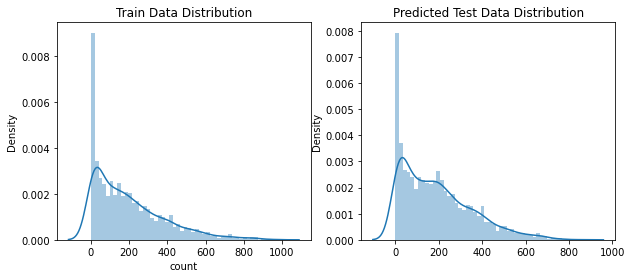

In [191]:
#Create a KNN model
knn = KNeighborsRegressor(n_neighbors=3, metric='euclidean', weights='distance') 

#Train the model using the training sets
knn.fit(X_train_knn, y_train)

#Make predictions for the test dataset
y_pred = knn.predict(X_val_knn)

#Proportion of correct predictions on the test set:
score = np.sqrt(-np.mean(cross_val_score(knn, X_val_knn, y_val, cv=5, scoring='neg_mean_squared_log_error')))

print(score)
plot('KNN', y_val, y_pred)

**Linear regression**

1.2765716257232391


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


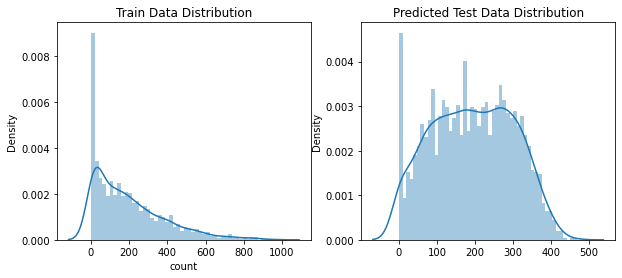

In [192]:
#Create new linearregression model
model = LinearRegression()

#Fit the model to training data
model.fit(X_train, y_train)

#Predict count value for validation data
y_pred = model.predict(X_val)

#If predicted value below 0, set value to 0
y_pred = [0 if i < 0 else i for i in y_pred]


print(np.sqrt(mean_squared_log_error(y_val, y_pred)))
plot('Linear Regression', y_val, y_pred)

**Random Forest Regressor**

0.49290944538816506


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


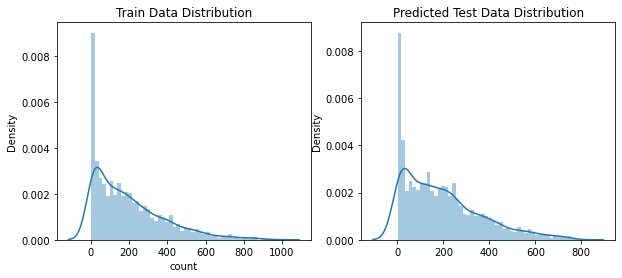

In [193]:
#Create new RandomForestRegressor 
model = RandomForestRegressor()

#Fit the model to training data
model.fit(X_train, y_train)

#Predict count value for validation data
y_pred = model.predict(X_val)


score = np.sqrt(-np.mean(cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_log_error')))
print(score)

plot('Random Forest Regressor', y_val, y_pred)

## Test 2 Split predictions into casual and registered

In [194]:
#Create two different target features, registered and casual
y_casual = train_df.iloc[:,10]
y_registered = train_df.iloc[:,11]

#Create two different training sets, one for casual and one for registered
X_casual = train_df.iloc[:,1:10]
X_registered = train_df.iloc[:,1:10]

#Split training data into 80/20 split
X_train_casual, X_val_casual, y_train_casual, y_val_casual = train_test_split(X_casual, y_casual, test_size=0.20, random_state=1)
X_train_registered, X_val_registered, y_train_registered, y_val_registered = train_test_split(X_registered, y_registered, test_size=0.20, random_state=1)

#End-target count will be the sum of casual and registered predictions
y_val_added = y_val_casual + y_val_registered

**kNN Regressor**

In [195]:
#Scale training sets to 0,1
X_train_casual_knn = scale(X_train_casual, 1,0)
X_val_casual_knn = scale(X_val_casual, 1,0)

X_train_registered_knn = scale(X_train_registered, 1,0)
X_val_registered_knn = scale(X_val_registered, 1,0)

0.8301487452979678


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


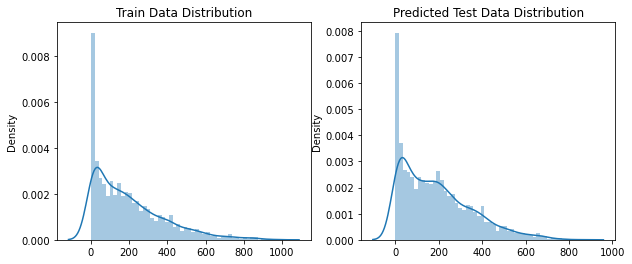

In [196]:
#Create a KNN model
knn_casual = KNeighborsRegressor(n_neighbors=3, metric='euclidean', weights='distance') 
knn_registered = KNeighborsRegressor(n_neighbors=3, metric='euclidean', weights='distance') 

#Train the model using the training sets
knn_casual.fit(X_train_casual_knn, y_train_casual)
knn_registered.fit(X_train_registered_knn, y_train_registered)

#Make predictions for the test dataset
y_pred_casual = knn_casual.predict(X_val_casual_knn)
y_pred_registered = knn_registered.predict(X_val_registered_knn)

y_pred_added = y_pred_casual + y_pred_registered

score1 = np.sqrt(-np.mean(cross_val_score(knn_casual, X_val_casual_knn, y_val_casual, cv=5, scoring='neg_mean_squared_log_error')))
score2 = np.sqrt(-np.mean(cross_val_score(knn_registered, X_val_registered_knn, y_val_registered, cv=5, scoring='neg_mean_squared_log_error')))
print((score1+score2)/2)

#Proportion of correct predictions on the test set:
plot('KNN',y_val_added,y_pred_added)

**Linear regression**

1.5180059485330812


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


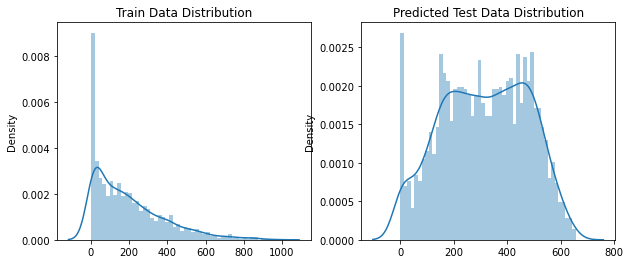

In [197]:
#Create a new Linearregression model
model = LinearRegression()

#Create two different linearregression models, one for casual and one for registered
model_casual = model.fit(X_train_casual, y_train_casual)
model_registered = model.fit(X_train_registered, y_train_registered)

#Make predictions for casual and registered users
y_pred_casual = model_casual.predict(X_val_casual)
y_pred_registered = model_registered.predict(X_val_registered)

#If predicted number of users < 0, set user to 0
y_pred_casual = np.array([0 if i < 0 else i for i in y_pred_casual])
y_pred_registered = np.array([0 if i < 0 else i for i in y_pred_registered])

y_pred_added = y_pred_casual + y_pred_registered

print(np.sqrt(mean_squared_log_error(y_val_added, y_pred_added)))
plot('Linear Regression', y_val_added, y_pred_added)

**Random Forest Regressor**

0.5625280476932953


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


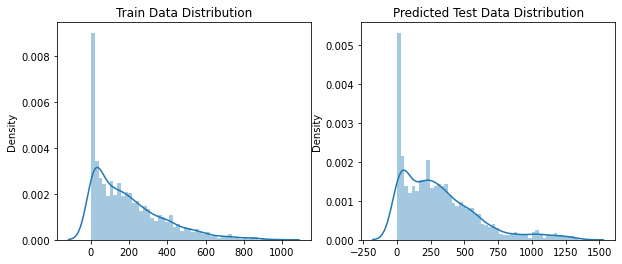

In [198]:
model = RandomForestRegressor()
#Create two different random forest regressors models, one for casual and one for registered
model_casual = model.fit(X_train_casual, y_train_casual)
model_registered = model.fit(X_train_registered, y_train_registered)

#Make predictions for casual and registered users
y_pred_casual = model_casual.predict(X_val_casual)
y_pred_registered = model_registered.predict(X_val_registered)

y_pred_added = y_pred_casual + y_pred_registered

score1 = np.sqrt(-np.mean(cross_val_score(model, X_val_casual, y_val_casual, cv=5, scoring='neg_mean_squared_log_error')))
score2 = np.sqrt(-np.mean(cross_val_score(model, X_val_registered, y_val_registered, cv=5, scoring='neg_mean_squared_log_error')))
print((score1+score2)/2)

plot('Random Forest Regressor', y_val_added, y_pred_added)

## Test 3 Feature selection

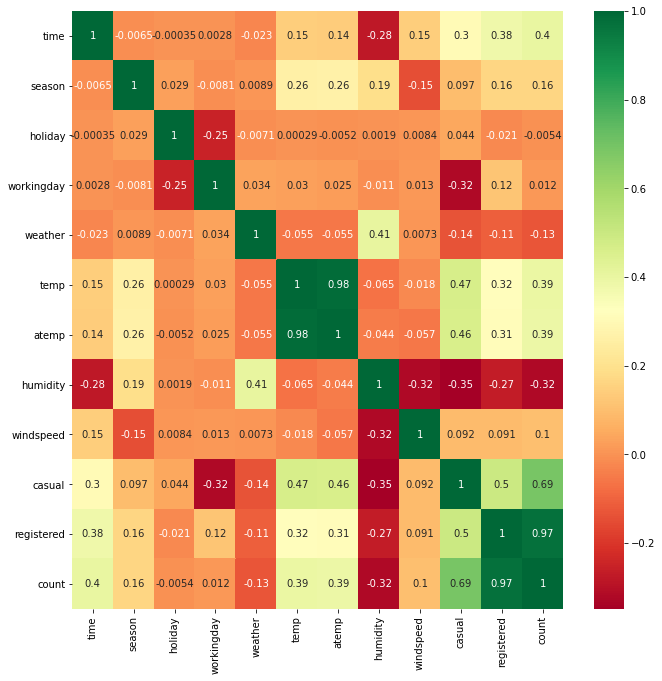

In [199]:
#Plot heat map
plt.figure(figsize=(11,11))
sns.heatmap(train_df.corr(),annot=True,cmap="RdYlGn")
plt.savefig('Heatmap', dpi=400)

In [200]:
#Drop columns with correlation < |0.2|
X_selected = train_df[['humidity','atemp','temp','time']]

#80/20 split
X_train_selected, X_val_selected, y_train_selected, y_val_selected = train_test_split(X_selected, y, test_size=0.20, random_state=1)

**kNN Regressor**

In [201]:
#Scale data for Knn model
X_train_selected_knn = scale(X_train_selected, 1,0)
X_val_selected_knn = scale(X_val_selected, 1,0)

0.8313533916747291


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


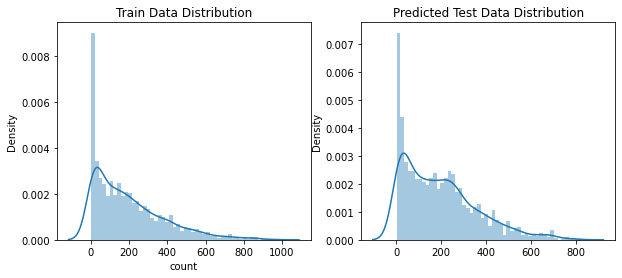

In [202]:
#Create a KNN model
knn = KNeighborsRegressor(n_neighbors=3, metric='euclidean', weights='distance') 

#Train the model using the training sets
knn.fit(X_train_selected_knn, y_train_selected)

#Make predictions for the validation data
y_pred = knn.predict(X_val_selected_knn)

#Proportion of correct predictions on the validation set:
score = np.sqrt(-np.mean(cross_val_score(knn, X_val_selected_knn, y_val_selected, cv=5, scoring='neg_mean_squared_log_error')))
print(score)
plot('KNN', y_val_selected, y_pred)

**Linear Regression**

1.227416641522075


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


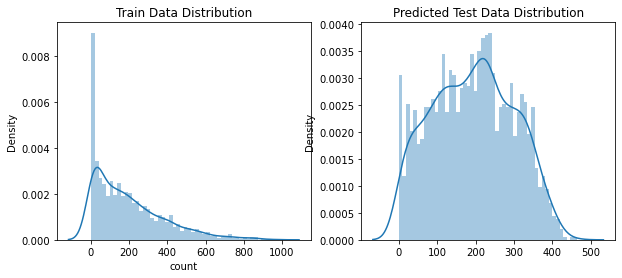

In [203]:
model = LinearRegression()

#Fit data to selected x and y data
model.fit(X_train_selected, y_train_selected)

y_pred = model.predict(X_val_selected)

#If predicted number of users < 0, set user to 0
y_pred = [0 if i < 0 else i for i in y_pred]

print(np.sqrt(mean_squared_log_error(y_val_selected, y_pred)))
plot('Linear Regression', y_val_selected, y_pred)

**Random Forest Regressor**

0.7508375480851031


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


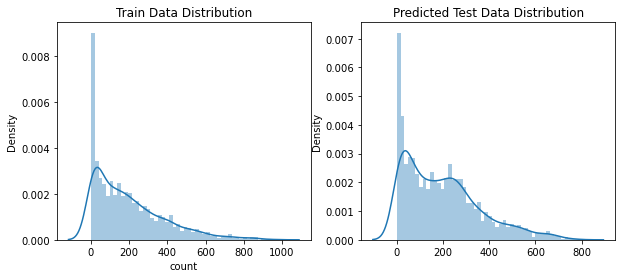

In [204]:
model = RandomForestRegressor()

#Train the model using the training sets
model.fit(X_train_selected, y_train_selected)

#Make predictions for the validation data
y_pred = model.predict(X_val_selected)

score = np.sqrt(-np.mean(cross_val_score(model, X_val_selected, y_val_selected, cv=5, scoring='neg_mean_squared_log_error')))
print(score)
plot('Random Forest Regressor', y_val_selected, y_pred)

## Test 4 transformation of hour data

In [205]:
sin = []
cos = []
#transform hour values from scale 0-23 to 0-360
for i in train_df['time']:
    sin.append(math.sin(math.radians(i*360/23)))
    cos.append(math.cos(math.radians(i*360/23)))

#Remove old time column and insert cos and sin values for time value
X_transformed = train_df.iloc[:,2:10]

X_transformed.insert(2, "time_cos", cos, True)  
X_transformed.insert(2, "time_sin", sin, True)

X_train_transformed, X_val_transformed, y_train_transformed, y_val_transformed = train_test_split(X_transformed, y, test_size=0.20, random_state=1)

X_transformed

,season,holiday,time_sin,time_cos,workingday,weather,temp,atemp,humidity,windspeed
0,1,0,0.000000e+00,1.000000,0,1,9.84,14.395,81,0.0000
1,1,0,2.697968e-01,0.962917,0,1,9.02,13.635,80,0.0000
2,1,0,5.195840e-01,0.854419,0,1,9.02,13.635,80,0.0000
3,1,0,7.308360e-01,0.682553,0,1,9.84,14.395,75,0.0000
4,1,0,8.878852e-01,0.460065,0,1,9.84,14.395,75,0.0000
...,...,...,...,...,...,...,...,...,...,...
10881,4,0,-8.878852e-01,0.460065,1,1,15.58,19.695,50,26.0027
10882,4,0,-7.308360e-01,0.682553,1,1,14.76,17.425,57,15.0013
10883,4,0,-5.195840e-01,0.854419,1,1,13.94,15.910,61,15.0013
10884,4,0,-2.697968e-01,0.962917,1,1,13.94,17.425,61,6.0032


**kNN Regressor**

In [206]:
#Scale data for Knn model
X_train_transformed_knn = scale(X_train_transformed, 1,0)
X_val_transformed_knn = scale(X_val_transformed, 1,0)

0.6132597029587852


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


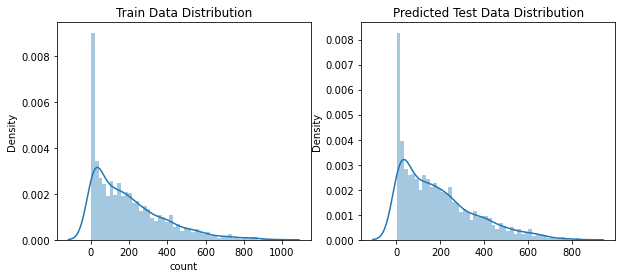

In [207]:
#Create a KNN model
knn = KNeighborsRegressor(n_neighbors=3, metric='euclidean', weights='distance') 

#Train the model using the training sets
knn.fit(X_train_transformed_knn, y_train)

#Make predictions for the test dataset
y_pred = knn.predict(X_val_transformed_knn)

#Proportion of correct predictions on the validation data:
score = np.sqrt(-np.mean(cross_val_score(knn, X_val_transformed_knn, y_val_transformed, cv=5, scoring='neg_mean_squared_log_error')))
print(score)
plot('KNN', y_val, y_pred)

**Linear regression**

1.1035087580693332


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


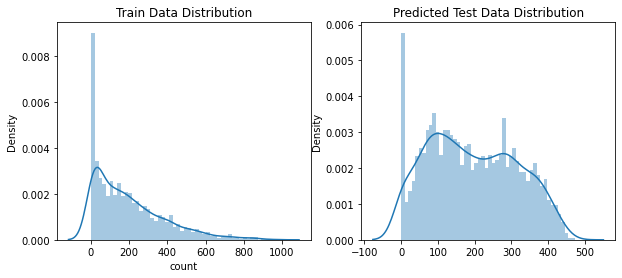

In [208]:
model = LinearRegression()

#Train data using transformed sets
model.fit(X_train_transformed, y_train_transformed)

y_pred = model.predict(X_val_transformed)

#If predicted number of users < 0, set user to 0
y_pred = [0 if i < 0 else i for i in y_pred]

print(np.sqrt(mean_squared_log_error(y_val_transformed, y_pred)))
plot('Linear Regression', y_val_transformed, y_pred)

**Random Forest Regressor**

0.5034626461374353


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


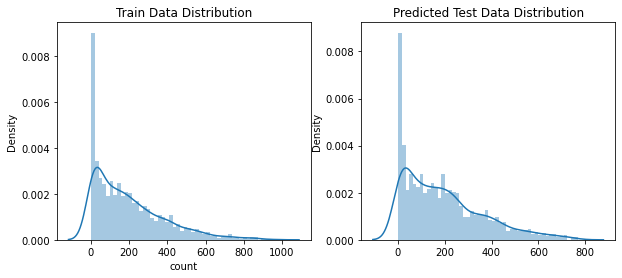

In [209]:
model = RandomForestRegressor()

#Train data using transformed sets
model.fit(X_train_transformed, y_train_transformed)

y_pred = model.predict(X_val_transformed)

score = np.sqrt(-np.mean(cross_val_score(model, X_val_transformed, y_val_transformed, cv=5, scoring='neg_mean_squared_log_error')))
print(score)
plot('Random Forest Regressor', y_val_transformed, y_pred)

## Test 5: Day and night

In [210]:
#Split dataframe intot two, one frame containing night entries and one fram containing day entries
day_df = train_df[(train_df['time'] <= 18) & (train_df['time'] > 6)]
night_df = train_df[(train_df['time'] > 18) | (train_df['time'] <= 6)]

X_day = day_df.iloc[:,1:10]
X_night = night_df.iloc[:,1:10]

y_day = day_df.iloc[:,12]
y_night = night_df.iloc[:,12]

X_train_day, X_val_day, y_train_day, y_val_day = train_test_split(X_day, y_day, test_size=0.20, random_state=1)
X_train_night, X_val_night, y_train_night, y_val_night = train_test_split(X_night, y_night, test_size=0.20, random_state=1)

**kNN Regressor**

In [211]:
#Scale frames for KNN
X_train_day_knn = scale(X_train_day, 1,0)
X_val_day_knn = scale(X_val_day, 1,0)
X_train_night_knn = scale(X_train_night, 1,0)
X_val_night_knn = scale(X_val_night, 1,0)

0.70356508380413


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


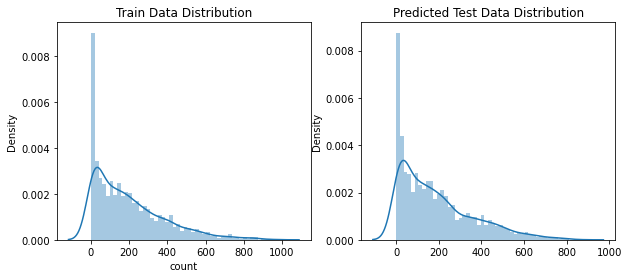

In [212]:
#Create a KNN model
knn_day = KNeighborsRegressor(n_neighbors=3, metric='euclidean', weights='distance') 
knn_night = KNeighborsRegressor(n_neighbors=3, metric='euclidean', weights='distance') 

#Train the model using the training sets
knn_day.fit(X_train_day_knn, y_train_day)
knn_night.fit(X_train_night_knn, y_train_night)

#Make predictions for the test dataset
y_pred_day = knn_day.predict(X_val_day_knn)
y_pred_night = knn_night.predict(X_val_night_knn)

y_pred = np.append(y_pred_day, y_pred_night)
y_val_temp = np.append(y_val_day, y_val_night)

score1 = np.sqrt(-np.mean(cross_val_score(knn_day, X_val_day_knn, y_val_day, cv=5, scoring='neg_mean_squared_log_error')))
score2 = np.sqrt(-np.mean(cross_val_score(knn_night, X_val_night_knn, y_val_night, cv=5, scoring='neg_mean_squared_log_error')))
print((score1+score2)/2)

plot('KNN', y_val, y_pred)

**Linear regression**

1.1424197067448734


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


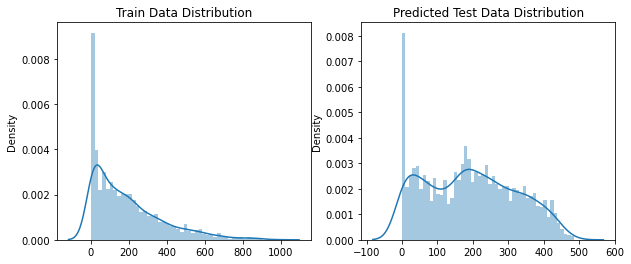

In [213]:
#Two separate models for day and night
model_day = LinearRegression()
model_night = LinearRegression()

#Fit models to training sets
model_day.fit(X_train_day, y_train_day)
model_night.fit(X_train_night, y_train_night)

#Make predictions for validation set
y_pred_day = model_day.predict(X_val_day)
y_pred_night = model_night.predict(X_val_night)

#If predicted value <0, set value to 0
y_pred_day = [0 if i < 0 else i for i in y_pred_day]
y_pred_night = [0 if i < 0 else i for i in y_pred_night]

y_pred = np.append(y_pred_day,y_pred_night)
y_val_temp = np.append(y_val_day,y_val_night)

print(np.sqrt(mean_squared_log_error(y_val_temp, y_pred)))
plot('Linear Regression', y_val_temp, y_pred)

**Random Forest Regressor**

0.49530753234330654


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


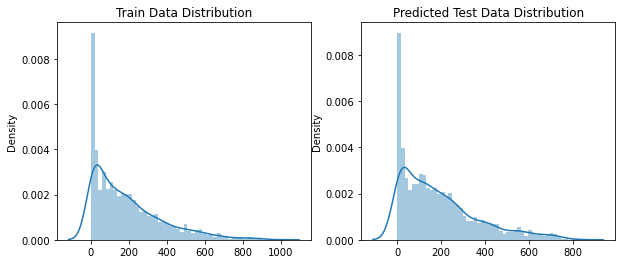

In [239]:
#Two separate models for day and night
model_day = RandomForestRegressor()
model_night = RandomForestRegressor()

#Fit models to training sets
model_day.fit(X_train_day, y_train_day)
model_night.fit(X_train_night, y_train_night)

#Make predictions for validation set
y_pred_day = model_day.predict(X_val_day)
y_pred_night = model_night.predict(X_val_night)

#If predicted value <0, set value to 0
y_pred = np.append(y_pred_day,y_pred_night)
y_val_temp = np.append(y_val_day,y_val_night)

score1 = np.sqrt(-np.mean(cross_val_score(model_day, X_val_day, y_val_day, cv=5, scoring='neg_mean_squared_log_error')))
score2 = np.sqrt(-np.mean(cross_val_score(model_night, X_val_night, y_val_night, cv=5, scoring='neg_mean_squared_log_error')))
print((score1+score2)/2)

plot('Random Forest Regressor', y_val_temp, y_pred)

## Test 6: Best Practice

**Random Forest Regressor**

0.49459268299509523


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


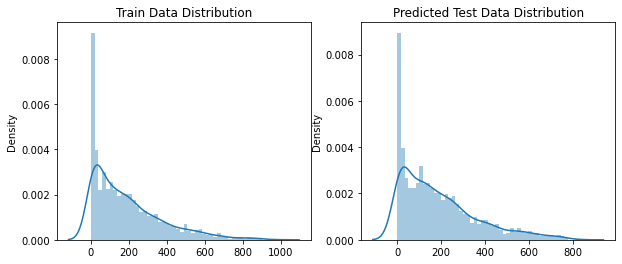

In [215]:
#Best model is RFR split into day and night
model_day = RandomForestRegressor()
model_night = RandomForestRegressor()

#Fit models to training sets
model_day.fit(X_train_day, y_train_day)
model_night.fit(X_train_night, y_train_night)

#Make predictions for validation set
y_pred_day = model_day.predict(X_val_day)
y_pred_night = model_night.predict(X_val_night)

y_pred = np.append(y_pred_day,y_pred_night)
y_val_temp = np.append(y_val_day,y_val_night)

score1 = np.sqrt(-np.mean(cross_val_score(model_day, X_val_day, y_val_day, cv=5, scoring='neg_mean_squared_log_error')))
score2 = np.sqrt(-np.mean(cross_val_score(model_night, X_val_night, y_val_night, cv=5, scoring='neg_mean_squared_log_error')))
print((score1+score2)/2)

plot('Random Forest Regressor', y_val_temp, y_pred)

## Hyperparameter selection

In [216]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [217]:
#Find best hyperparameters
rf_random_day = RandomizedSearchCV(estimator = model_day, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=1, n_jobs = -1)

rf_random_day.fit(X_train_day, y_train_day)

rf_random_day.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

In [218]:
rf_random_night = RandomizedSearchCV(estimator = model_night, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random_night.fit(X_train_night, y_train_night)

rf_random_night.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


{'n_estimators': 700,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

0.47793104665831404


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


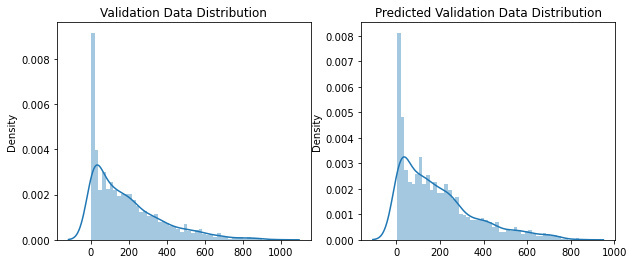

In [242]:
#Make new predictions for validation set
y_pred_day = rf_random_day.predict(X_val_day)
y_pred_night = rf_random_night.predict(X_val_night)

y_pred = np.append(y_pred_day,y_pred_night)
y_val_temp = np.append(y_val_day,y_val_night)

print(np.sqrt(mean_squared_log_error(y_val_temp, y_pred)))

plot('Random Forest Regressor', y_val_temp, y_pred)

## Final test

In [220]:
#load test values
test_df

,datetime,time,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,0,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,2,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,3,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,4,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,19,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,20,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,21,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,22,1,0,1,1,10.66,13.635,56,8.9981


In [235]:
#Remove datetime for test values
X_test = test_df.iloc[:,1:10]
results = test_df.iloc[:,0:1]

X_test

,time,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,0,1,0,1,1,10.66,11.365,56,26.0027
1,1,1,0,1,1,10.66,13.635,56,0.0000
2,2,1,0,1,1,10.66,13.635,56,0.0000
3,3,1,0,1,1,10.66,12.880,56,11.0014
4,4,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,19,1,0,1,2,10.66,12.880,60,11.0014
6489,20,1,0,1,2,10.66,12.880,60,11.0014
6490,21,1,0,1,1,10.66,12.880,60,11.0014
6491,22,1,0,1,1,10.66,13.635,56,8.9981


In [236]:
results

,datetime
0,2011-01-20 00:00:00
1,2011-01-20 01:00:00
2,2011-01-20 02:00:00
3,2011-01-20 03:00:00
4,2011-01-20 04:00:00
...,...
6488,2012-12-31 19:00:00
6489,2012-12-31 20:00:00
6490,2012-12-31 21:00:00
6491,2012-12-31 22:00:00


In [223]:
predictions = results['datetime'].to_numpy()

In [224]:
#Make predicitons based on the current row is a day or night entry
for index, row in X_test.iterrows():
    if ((row['time'] <= 18) & (row['time'] > 6)):
        pred = model_day.predict(np.array(row).reshape(1,-1))
        predictions[index] = pred
    else:
        pred = model_night.predict(np.array(row).reshape(1,-1))
        predictions[index] = pred
    print("Progress: " + str(index) + '/' + str(len(X_test)))

Progress: 0/6493
Progress: 1/6493
Progress: 2/6493
Progress: 3/6493
Progress: 4/6493
Progress: 5/6493
Progress: 6/6493
Progress: 7/6493
Progress: 8/6493
Progress: 9/6493
Progress: 10/6493
Progress: 11/6493
Progress: 12/6493
Progress: 13/6493
Progress: 14/6493
Progress: 15/6493
Progress: 16/6493
Progress: 17/6493
Progress: 18/6493
Progress: 19/6493
Progress: 20/6493
Progress: 21/6493
Progress: 22/6493
Progress: 23/6493
Progress: 24/6493
Progress: 25/6493
Progress: 26/6493
Progress: 27/6493
Progress: 28/6493
Progress: 29/6493
Progress: 30/6493
Progress: 31/6493
Progress: 32/6493
Progress: 33/6493
Progress: 34/6493
Progress: 35/6493
Progress: 36/6493
Progress: 37/6493
Progress: 38/6493
Progress: 39/6493
Progress: 40/6493
Progress: 41/6493
Progress: 42/6493
Progress: 43/6493
Progress: 44/6493
Progress: 45/6493
Progress: 46/6493
Progress: 47/6493
Progress: 48/6493
Progress: 49/6493
Progress: 50/6493
Progress: 51/6493
Progress: 52/6493
Progress: 53/6493
Progress: 54/6493
Progress: 55/6493
Pr

In [232]:
print(predictions)

[array([13.57]) array([6.202]) array([5.28]) ... array([84.48666667])
 array([95.394]) array([43.89])]


In [237]:
#Prepare results for kaggle challenge hand-in
results
results['count'] = predictions
results.to_csv('results2.csv', index = False)

/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
